# Sentiment analysis

In this notebook we perform sentiment analysis on the preprocessed Food.com dataset using a variety of NLP models.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob
from transformers import pipeline
from tqdm import tqdm
tqdm.pandas()

In [2]:
pd.set_option('display.max_colwidth',None)
pd.set_option('display.float_format',lambda x: '%.2f' % x)

In [3]:
df_full = pd.read_pickle('preprocessed_dataset.pkl')

In [4]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1132367 entries, 0 to 1132366
Data columns (total 17 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   user_id            1132367 non-null  int64         
 1   recipe_id          1132367 non-null  int64         
 2   date               1132367 non-null  datetime64[ns]
 3   rating             1132367 non-null  int64         
 4   minutes            1132367 non-null  int64         
 5   contributor_id     1132367 non-null  int64         
 6   submitted          1132367 non-null  datetime64[ns]
 7   nutrition          1132367 non-null  object        
 8   n_steps            1132367 non-null  int64         
 9   n_ingredients      1132367 non-null  int64         
 10  plain_review       1132367 non-null  object        
 11  plain_tags         1132367 non-null  object        
 12  plain_name         1132367 non-null  object        
 13  plain_description  1132367 

In [5]:
df_full.head()

,user_id,recipe_id,date,rating,minutes,contributor_id,submitted,nutrition,n_steps,n_ingredients,plain_review,plain_tags,plain_name,plain_description,plain_ingredients,review,nostop_review
0,38094,40893,2003-02-17,4,495,1533,2002-09-21,"[204.8, 5.0, 9.0, 26.0, 24.0, 2.0, 10.0]",4,9,"[great, salad, cooked, top, stove, 15, minutesadded, shake, cayenne, pinch, salt, used, low, fat, sour, cream, thanks]","[weeknight, time-to-make, course, main-ingredient, preparation, occasion, soups-stews, beans, vegetables, easy, crock-pot-slow-cooker, dietary, equipment]","[white, bean, green, chile, pepper, soup]","[easy, soup, crockpot]","[great, northern, beans, yellow, onion, diced, green, chilies, ground, cumin, garlic, powder, fat-free, chicken, broth, fresh, cilantro, leaves, extra, virgin, olive, oil, sour, cream]",Great with a salad. Cooked on top of stove for 15 minutes.Added a shake of cayenne and a pinch of salt. Used low fat sour cream. Thanks.,great salad. cooked top stove 15 minutes.added shake cayenne pinch salt. used low fat sour cream. thanks.
1,1293707,40893,2011-12-21,5,495,1533,2002-09-21,"[204.8, 5.0, 9.0, 26.0, 24.0, 2.0, 10.0]",4,9,"[simple, delicious, great, chilly, fall, evening, doubled, <br/><br/>second, time, around, forgot, remaining, cumin, usually, love, cumin, didn't, notice, missing, 1/2, teaspoon]","[weeknight, time-to-make, course, main-ingredient, preparation, occasion, soups-stews, beans, vegetables, easy, crock-pot-slow-cooker, dietary, equipment]","[white, bean, green, chile, pepper, soup]","[easy, soup, crockpot]","[great, northern, beans, yellow, onion, diced, green, chilies, ground, cumin, garlic, powder, fat-free, chicken, broth, fresh, cilantro, leaves, extra, virgin, olive, oil, sour, cream]","So simple, so delicious! Great for chilly fall evening. Should have doubled it ;)<br/><br/>Second time around, forgot the remaining cumin. We usually love cumin, but didn't notice the missing 1/2 teaspoon!","simple, delicious! great chilly fall evening. doubled ;)<br/><br/>second time around, forgot remaining cumin. usually love cumin, didn't notice missing 1/2 teaspoon!"
2,8937,44394,2002-12-01,4,20,56824,2002-10-27,"[132.3, 11.0, 39.0, 5.0, 4.0, 11.0, 5.0]",5,4,"[worked, well, easy, used, quite, whole, package, 10oz, white, chips, great]","[30-minutes-or-less, time-to-make, course, main-ingredient, preparation, occasion, for-large-groups, 5-ingredients-or-less, drop-cookies, desserts, lunch, oven, easy, potluck, fall, finger-food, heirloom-historical, holiday-event, kid-friendly, picnic, spring, summer, winter, cakes, cookies-and-brownies, easter, chocolate, dietary, gifts, christmas, hanukkah, new-years, seasonal, comfort-food, independence-day, ramadan, rosh-hashana, valentines-day, taste-mood, to-go, equipment, number-of-servings, presentation]","[devilicious, cookie, cake, delights]",[nan],"[""devils, food, cake, mix"", vegetable, oil, eggs, ""reeses, pieces""]",This worked very well and is EASY. I used not quite a whole package (10oz) of white chips. Great!,worked well easy. used quite whole package (10oz) white chips. great!
3,126440,85009,2010-02-27,5,10,64342,2004-02-25,"[2786.2, 342.0, 134.0, 290.0, 161.0, 301.0, 42.0]",3,13,"[made, mexican, topping, took, bunko, everyone, loved, it]","[15-minutes-or-less, time-to-make, course, main-ingredient, preparation, condiments-etc, vegetables, easy, inexpensive, number-of-servings, 3-steps-or-less]","[baked, potato, toppings]","[toppings, sure, makes, nice, change, plain, old, sour, cream, bacon, bitsyou, use, regular, light, fat, free, calorie, reduced, mayonnaise]","[mayonnaise, salsa, cheddar, cheese, refried, beans, ham, green, pepper, tomatoes, cooked, bacon, pepperoni, mozzarella, cheese, parmesan, cheese, pizza, sauce, frozen, chopped, broccoli]",I made the Mexican topping and took it to bunko. Everyone loved it.,made mexican topping took bunko. everyone loved it.
4,57222,85009,2011-10-01,5,10,64342,2004-02-25,"[2786.2, 342.0, 134.0, 290.0, 161.0, 301.

Let's try one simple model called TextBlob, which is a lexicon-based sentiment analyser. This means that it assigns a score (positive, towards +1, for more positive texts; negative, towards -1, for more negative texts; 0 for neutral texts) to individual words in the text and then combines them into an overall score. We perform the analysis using both the complete reviews and the reviews without stopwords.

In [10]:
df_full['sentiment_1'] = df_full.review.astype(str).apply(lambda text: TextBlob(text).sentiment[0])

In [11]:
df_full['sentiment_2'] = df_full.nostop_review.astype(str).apply(lambda text: TextBlob(text).sentiment[0])

As we see in the following, the results of TextBlob on the two different formats of reviews are generally fairly similar. However, we clearly see that some results are off (e.g., the rwviews with id equal to 7, 10, 11). This is maybe related to the fact that just the presence of certain words in the text can greatly impact the result of the model, because it does not take into consideration the relation between adjacent words, which in turn can greatly affect their meaning. 

In [10]:
df_full[['review','sentiment_1','sentiment_2']].head(20)

,review,sentiment_1,sentiment_2
0,Great with a salad. Cooked on top of stove for 15 minutes.Added a shake of cayenne and a pinch of salt. Used low fat sour cream. Thanks.,0.27,0.27
1,"So simple, so delicious! Great for chilly fall evening. Should have doubled it ;)<br/><br/>Second time around, forgot the remaining cumin. We usually love cumin, but didn't notice the missing 1/2 teaspoon!",0.24,0.24
2,This worked very well and is EASY. I used not quite a whole package (10oz) of white chips. Great!,0.37,0.41
3,I made the Mexican topping and took it to bunko. Everyone loved it.,0.35,0.35
4,"Made the cheddar bacon topping, adding a sprinkling of black pepper. Yum!",-0.21,-0.21
5,very very sweet. after i waited the 2 days i bought 2 more pints of raspberries and added them to the mix. i'm going to add some as a cake filling today and will take a photo.,0.48,0.35
6,"Just an observation, so I will not rate. I followed this procedure with strawberries instead of raspberries. Perhaps this is the reason it did not work well. Sorry to report that the strawberries I did in August were moldy in October. They were stored in my downstairs fridge, which is very cold and infrequently opened. Delicious and fresh-tasting prior to that, though. So, keep a sharp eye on them. Personally I would not keep them longer than a month. This recipe also appears as #120345 posted in July 2009, which is when I tried it. I also own the Edna Lewis cookbook in which this appears.",0.03,-0.04
7,"This recipe was OVERLY too sweet. I would start out with 1/3 or 1/4 cup of sugar and jsut add on from there. Just 2 cups was way too much and I had to go back to the grocery store to buy more raspberries because it made so much mix. Overall, I would but the long narrow box or raspberries. Its a perfect fit for the recipe plus a little extra. I was not impressed with this recipe. It was exceptionally over-sweet. If you make this simple recipe, MAKE SURE TO ADD LESS SUGAR!",0.16,0.23
8,Very good!,1.00,0.88
9,Better than the real!!,0.41,0.41


For this reason, we try more elaborate models, specifically those based on transformers, which represent the state of the art in NLP. Given than these models are extremely complex, we use some pre-trained models made available by Hugging Face: https://huggingface.co/models?language=en&library=tf&pipeline_tag=text-classification&sort=downloads&search=sentiment.

In [19]:
sentiment_pipeline = pipeline("sentiment-analysis")
#sentiment_pipeline = pipeline(model='finiteautomata/bertweet-base-sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceCla

In [20]:
sentiment_pipeline(df_full.nostop_review[7])

[{'label': 'NEGATIVE', 'score': 0.9475618600845337}]

Since the transformer model is quite complex and the dataset contains a huge number of reviews, we can select a smaller subsample.

In [26]:
df_subset = df_full.sample(10000)

In [49]:
df_subset['sentiment_3'] = df_subset.review.astype(str).progress_apply(lambda text: sentiment_pipeline(text[:500]))

100%|██████████| 10000/10000 [30:03<00:00,  5.54it/s]


In [51]:
df_subset.to_pickle('sentiment_dataset.pkl')

In [3]:
df_subset = pd.read_pickle('sentiment_dataset.pkl')

Let's visualise the distribution of the reviews sentiments according to the different models. As we see, the transformer model predicts a much more polarised setting, where most reviews are extremely positive and the second most frequent case is that of extremely negative reviews. This is in agreement to what was shown in the notebook <code>preprocess_dataset.ipynb</code>, where the distribution of ratings showed a similarly polarised view of the recipes. On the other hand, the TextBlob model uncorrectly sees most reviews as slightly positive.

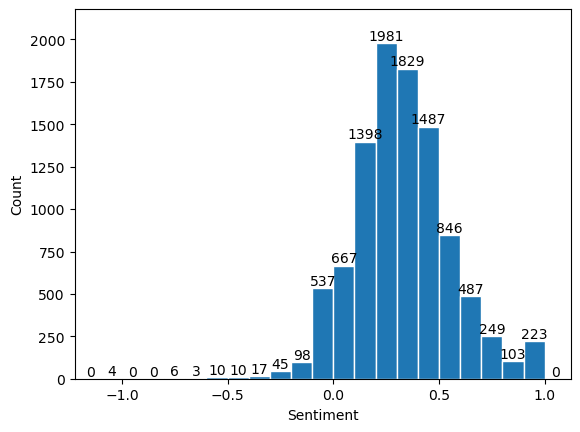

In [30]:
values, bins, bars = plt.hist(df_subset['sentiment_1'],bins=np.arange(-1.2,1.2,0.1),edgecolor='white')
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.bar_label(bars, fontsize=10)
plt.margins(x=0.01, y=0.1)
plt.show()

In [58]:
print(df_subset['sentiment_3'].iloc[4][0]['score'],df_subset['sentiment_3'].iloc[4][0]['label'])
[df_subset['sentiment_3'].iloc[i][0]['score'] if df_subset['sentiment_3'].iloc[i][0]['label']=='POSITIVE' else -df_subset['sentiment_3'].iloc[i][0]['score'] for i in range(len(df_subset))]

0.9996880292892456 POSITIVE


[0.9850731492042542,
 0.9997662901878357,
 0.999729335308075,
 0.9881729483604431,
 0.9996880292892456,
 0.9998509883880615,
 0.9971981048583984,
 0.9998273849487305,
 0.9992862343788147,
 0.9562954306602478,
 0.9983435869216919,
 -0.9920921921730042,
 -0.9942389726638794,
 0.9920021295547485,
 0.999431312084198,
 0.9996172189712524,
 0.9975054860115051,
 0.9934087991714478,
 0.9997984766960144,
 0.9623603224754333,
 0.9994081258773804,
 -0.9992690682411194,
 0.8402449488639832,
 0.99956876039505,
 0.993704617023468,
 -0.9633143544197083,
 0.9997169375419617,
 0.9995720982551575,
 0.9996606111526489,
 0.9991613626480103,
 -0.9909446239471436,
 0.9993590712547302,
 0.9998220801353455,
 0.9987871050834656,
 0.9996519088745117,
 0.9998581409454346,
 -0.9969624876976013,
 -0.9640015959739685,
 0.9926862716674805,
 0.9997040629386902,
 0.9541466236114502,
 0.9993590712547302,
 0.9998699426651001,
 0.9993550181388855,
 0.9998296499252319,
 0.9993508458137512,
 0.9929550290107727,
 0.99600875

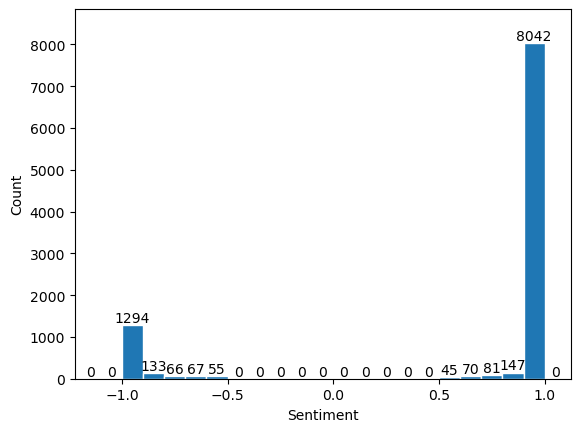

In [59]:
sent_3 = [df_subset['sentiment_3'].iloc[i][0]['score'] if df_subset['sentiment_3'].iloc[i][0]['label']=='POSITIVE' else -df_subset['sentiment_3'].iloc[i][0]['score'] for i in range(len(df_subset))]

values, bins, bars = plt.hist(sent_3,bins=np.arange(-1.2,1.2,0.1),edgecolor='white')
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.bar_label(bars, fontsize=10)
plt.margins(x=0.01, y=0.1)
plt.show()